# California Housing Prices: Regresión con PyTorch y Weights & Biases

En esta notebook, implementaremos un modelo de regresión para predecir valores medianos de casas basado en un conjunto de datos de características demográficas y geográficas. Además, presentaremos los aspectos básicos del entrenamiento de modelos en PyTorch y utilizaremos la herramienta Weights & Biases (W&B) para el seguimiento y visualización de los experimentos.

## Introduction

### Objetivos

1. **Implementar un modelo de regresión** utilizando PyTorch.
2. **Configurar y utilizar W&B** para el seguimiento de métricas y visualización de resultados.

### Contenido

1. Configuración de bibliotecas y semillas para reproducibilidad.
2. Carga y exploración del dataset `housing.csv`.
3. Preparación de datos y división en conjuntos de entrenamiento y prueba.
4. Definición y entrenamiento de un modelo de regresión en PyTorch.
5. Integración de W&B para el seguimiento de experimentos y visualización de métricas.

### Sobre el conjunto de datos

Los datos se refieren a las casas que se encuentran en un determinado distrito de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Hay que tener en cuenta que los datos no están depurados, por lo que se requieren algunos pasos de preprocesamiento. El objetivo es predecir el valor medio de las casas para los distritos de California, por lo que se trata de un problema de regresión.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchinfo import summary

from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.backends.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando mps
Usando 0


In [4]:

BATCH_SIZE = 1024  # tamaño del batch

## Carga de datos + Exploración

In [5]:
california_housing = fetch_california_housing(as_frame=True)
target_column_name = california_housing.target_names[0]  # 'MedHouseVal'
print(target_column_name)
print(california_housing.DESCR)

MedHouseVal
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using on

In [6]:
df = california_housing.frame  # Convertimos el dataset en un DataFrame de pandas
df.head()  # Mostramos las primeras filas del DataFrame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
df.describe()  # Mostramos un resumen de las estadísticas del DataFrame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [8]:
# Chequear si hay valores nulos
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Afortunadamente, el conjunto de datos no tiene valores faltantes, por lo que podemos ignorar la imputación de datos.

In [9]:
# Crear la matriz de correlación
correlation_matrix = df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge    -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms     0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms   -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population   0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup     0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
Latitude    -0.079809  0.011173  0.106389   0.069721   -0.108785  0.002366   
Longitude   -0.015176 -0.108197 -0.027540   0.013344    0.099773  0.002476   
MedHouseVal  0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

             Latitude  Longitude  MedHouseVal  
MedInc      -0.079809  -0.015176     0.688075  
HouseAge     0.011173  -0.108197     0.105623  
AveRooms     0.106389  -0.027540     0.151948  
AveBedrms    0.069721   0.0

En este momento vemos que existen relaciones fuertes entre algunas variables como `MedInc`, `HouseAge`, y `AveRooms`  con `MedHouseVal`, lo cual suena lógico. Podríamos descartar algunas variables que no aportan mucho valor al modelo, pero por simplicidad, las mantendremos todas.

## Preprocesamiento de datos

Para el preprocesamiento de datos nos vamos a limitar a la normalización de los datos. La normalización es una técnica común en el aprendizaje automático para mejorar la convergencia y la estabilidad del modelo. En este caso, normalizaremos todas las variables a un rango de 0 a 1.

In [10]:
dfn = df.drop(
    columns=target_column_name
)  # Eliminar la columna objetivo 'MedHouseVal' del DataFrame y normalizar el resto de columnas
dfn = (dfn - dfn.mean()) / dfn.std()  # Normalizamos las columnas

dfn[target_column_name] = df[
    target_column_name
]  # Añadir la columna objetivo 'MedHouseVal' de nuevo al DataFrame normalizado

dfn.describe()  # Mostramos un resumen de las estadísticas del DataFrame normalizado

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,20640.000000
mean,4.406467e-17,1.101617e-17,6.885104e-17,-1.018995e-16,-1.514723e-17,2.754042e-18,-1.035520e-15,-8.526513e-15,2.068558
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.153956
min,-1.774256e+00,-2.196127e+00,-1.852274e+00,-1.610729e+00,-1.256092e+00,-2.289944e-01,-1.447533e+00,-2.385935e+00,0.149990
25%,-6.881019e-01,-8.453727e-01,-3.994399e-01,-1.911670e-01,-5.637952e-01,-6.170912e-02,-7.967694e-01,-1.113182e+00,1.196000
50%,-1.767908e-01,2.864502e-02,-8.078293e-02,-1.010626e-01,-2.291262e-01,-2.431526e-02,-6.422715e-01,5.389006e-01,1.797000
75%,4.592952e-01,6.642943e-01,2.519554e-01,6.015724e-03,2.644885e-01,2.037404e-02,9.729330e-01,7.784775e-01,2.647250
max,5.858144e+00,1.856137e+00,5.516190e+01,6.957003e+01,3.024960e+01,1.194162e+02,2.957996e+00,2.625216e+00,5.000010


## Dataset y DataLoader

**Dataset**

En PyTorch, un `Dataset` es una clase que se encarga de cargar y preparar los datos para su posterior uso en el entrenamiento de modelos. Este objeto almacena los datos y proporciona un método para acceder a ellos de manera eficiente y estructurada. Generalmente, `Dataset` se personaliza según el tipo de datos que se maneja, por ejemplo, imágenes, texto o series temporales. Su implementación básica requiere definir los métodos `__len__` para devolver el tamaño del dataset y `__getitem__` para acceder a un elemento específico.

Más información sobre `Dataset` en la documentación oficial de PyTorch: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

**DataLoader**

El `DataLoader` es una clase que se utiliza para envolver un objeto `Dataset` y proporciona un acceso fácil a los datos en lotes durante el entrenamiento, además de otras funcionalidades como el barajado (shuffling) de datos y la carga paralela utilizando múltiples subprocesos. Esto es crucial para el entrenamiento eficiente de modelos, especialmente con grandes volúmenes de datos, ya que gestiona el uso de memoria y mejora el rendimiento computacional.

Más información sobre `DataLoader` en la documentación oficial de PyTorch: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

**Objetivo y Uso**

El uso conjunto de `Dataset` y `DataLoader` en PyTorch es fundamental para el flujo de trabajo de entrenamiento de modelos de aprendizaje automático. `Dataset` se encarga de la estructura y accesibilidad de los datos, mientras que `DataLoader` optimiza el proceso de iteración sobre los datos en lotes y facilita operaciones como la mezcla y la carga paralela. Esto permite que el entrenamiento de modelos sea más escalable y eficiente.


### Datasets

In [11]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self, dataframe, target_column):
        self.x = dataframe.drop(columns=target_column).values
        self.y = dataframe[target_column].values

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor([self.y[idx]], dtype=torch.float32)
        return x, y
        


dataset = CaliforniaHousingDataset(dfn, target_column_name)

In [12]:
dataset[0]

(tensor([ 2.3447,  0.9821,  0.6285, -0.1538, -0.9744, -0.0496,  1.0525, -1.3278]),
 tensor([4.5260]))

Dividimos el conjunto de datos en tres partes: entrenamiento, validación y prueba. La división se realiza de forma aleatoria, utilizando el 80% de los datos para entrenamiento, el 10% para validación y el 10% restante para pruebas. 

In [13]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = (
    total_size - train_size - val_size
)  # nos aseguramos de que el tamaño del conjunto de test sea correcto

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

### DataLoaders

Definimos los dataloaders para cada conjunto de datos, estos son los que se encargan de cargar los datos en lotes durante el entrenamiento y la evaluación del modelo.

In [14]:
def get_data_loaders(batch_size, num_workers):

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)

    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

    test_loader =  DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader

In [15]:
train_loader = get_data_loaders(BATCH_SIZE, NUM_WORKERS)

In [16]:
train_it = iter(train_loader)

In [17]:
next(train_it)

In [18]:
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE, NUM_WORKERS) # obtenemos los dataloaders

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)
print(x_batch[1])

torch.Size([1024, 8]) torch.Size([1024, 1])
tensor([-0.0306, -1.1632,  0.2073, -0.1327,  0.3192,  0.0272,  1.4130, -0.9435])


In [19]:
# pordemos recorrer un barch con un bucle
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)

torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([128, 8]) torch.Size([128, 1])


## Modelo

A continuación, definimos un modelo de regresión lineal simple utilizando PyTorch. 

In [26]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.hidden = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x


input_len = (
    len(dfn.columns) - 1
)  # Calculamos la cantidad de inputs como la cantidad de columnas -1 (el target)

summary(MLP(input_len), input_size=(BATCH_SIZE, input_len))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1024, 1]                 --
├─Linear: 1-1                            [1024, 64]                576
├─Linear: 1-2                            [1024, 32]                2,080
├─Linear: 1-3                            [1024, 1]                 33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.75
Input size (MB): 0.03
Forward/backward pass size (MB): 0.79
Params size (MB): 0.01
Estimated Total Size (MB): 0.84

## Entrenamiento

Vamos a definir una función de entrenamiento que se encargará de iterar sobre los datos de entrenamiento, calcular las predicciones del modelo, calcular la pérdida y actualizar los pesos del modelo utilizando el optimizador.

Tamibén definimos una función de evaluación que se encargará de calcular la pérdida y otras métricas de evaluación en el conjunto de validación.

In [32]:
def evaluate(model, criterion, data_loader):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    avg_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            output = model(x)
            loss = criterion(output, y)
            avg_loss += loss.item()
    avg_loss /= len(data_loader)
    return avg_loss


def train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs=10,
    log_fn=None,
    log_every=1,
):
    """
    Entrena el modelo utilizando el optimizador y la función de pérdida proporcionados.

    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        optimizer (torch.optim.Optimizer): El optimizador que se utilizará para actualizar los pesos del modelo.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        train_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de entrenamiento.
        val_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de validación.
        epochs (int): Número de épocas de entrenamiento (default: 10).
        log_fn (function): Función que se llamará después de cada log_every épocas con los argumentos (epoch, train_loss, val_loss) (default: None).
        log_every (int): Número de épocas entre cada llamada a log_fn (default: 1).

    Returns:
        Tuple[List[float], List[float]]: Una tupla con dos listas, la primera con el error de entrenamiento de cada época y la segunda con el error de validación de cada época.

    """
    epoch_train_loss = []  # colectamos el error de traing para posterior analisis
    epoch_val_errors = []  # colectamos el error de validacion para posterior analisis

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            # limpiamos los gradientes
            optimizer.zero_grad()

            output = model(x)
            loss = criterion(output, y)
            # backward actualiza los gradientes
            loss.backward()
            # actualiza los pesos
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        epoch_train_loss.append(epoch_loss)
        epoch_val_loss = evaluate(model, criterion, val_loader)
        epoch_val_errors.append(epoch_val_loss)

        if log_fn is not None:
            if (epoch + 1) % log_every == 0:
                log_fn(epoch + 1, epoch_loss, epoch_val_loss)

    return epoch_train_loss, epoch_val_errors

Definimos hiperparámetros como el número de épocas, la tasa de aprendizaje y la función de pérdida.

In [33]:
# Definimos los hiperparámetros
LR = 0.01
CRITERION = nn.MSELoss().to(DEVICE)
EPOCHS = 100

In [35]:
def print_log(epoch, train_loss, val_loss):
    print(
        f"Epoch: {epoch :03d}/{EPOCHS:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}"
    )

model = MLP(input_len).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, print_log, 5
)

Epoch: 005/100 | Train Loss: 0.68049 | Val Loss: 0.53305
Epoch: 010/100 | Train Loss: 0.58815 | Val Loss: 0.46840
Epoch: 015/100 | Train Loss: 0.54855 | Val Loss: 0.44714
Epoch: 020/100 | Train Loss: 0.52181 | Val Loss: 0.43074
Epoch: 025/100 | Train Loss: 0.50088 | Val Loss: 0.42163
Epoch: 030/100 | Train Loss: 0.47674 | Val Loss: 0.41141
Epoch: 035/100 | Train Loss: 0.46815 | Val Loss: 0.40440
Epoch: 040/100 | Train Loss: 0.45831 | Val Loss: 0.39718
Epoch: 045/100 | Train Loss: 0.44927 | Val Loss: 0.39733
Epoch: 050/100 | Train Loss: 0.45190 | Val Loss: 0.39523
Epoch: 055/100 | Train Loss: 0.43123 | Val Loss: 0.38752
Epoch: 060/100 | Train Loss: 0.42539 | Val Loss: 0.38217
Epoch: 065/100 | Train Loss: 0.42355 | Val Loss: 0.38021
Epoch: 070/100 | Train Loss: 0.41818 | Val Loss: 0.37683
Epoch: 075/100 | Train Loss: 0.40831 | Val Loss: 0.37438
Epoch: 080/100 | Train Loss: 0.40886 | Val Loss: 0.37200
Epoch: 085/100 | Train Loss: 0.41132 | Val Loss: 0.36699
Epoch: 090/100 | Train Loss: 0.

### Loss durante el entrenamiento

Es importante tener en cuenta que la pérdida es una medida de cuán bien se está desempeñando el modelo en el conjunto de entrenamiento. Sin embargo, la pérdida por sí sola no proporciona una visión completa del rendimiento del modelo. Por lo tanto, es fundamental evaluar el modelo en un conjunto de validación independiente para obtener una idea más precisa de su capacidad para generalizar a datos no vistos.

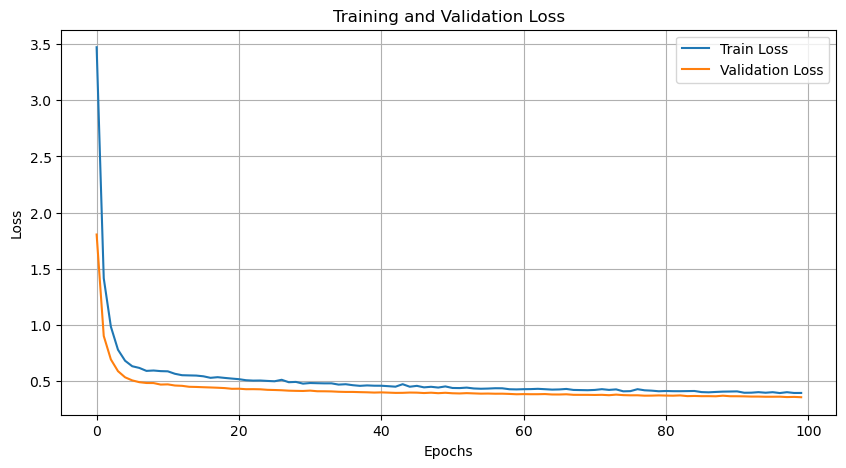

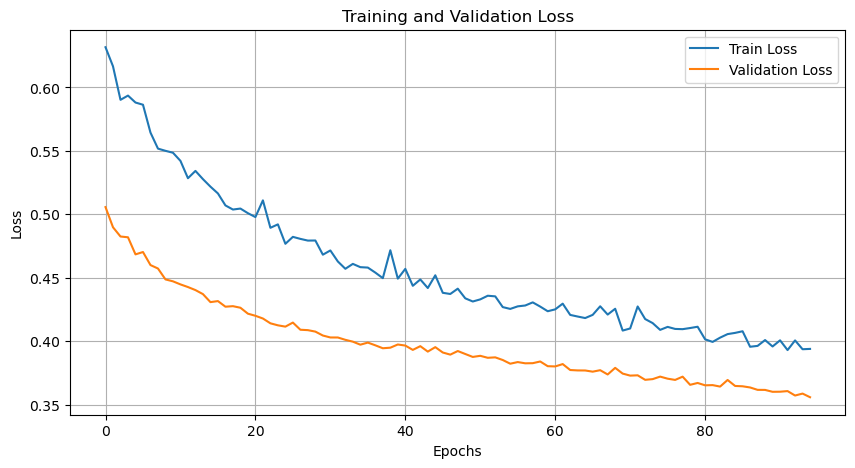

In [36]:
def plot_taining(train_errors, val_errors):
    # Graficar los errores
    plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
    plt.plot(train_errors, label="Train Loss")  # Grafica la pérdida de entrenamiento
    plt.plot(val_errors, label="Validation Loss")  # Grafica la pérdida de validación
    plt.title("Training and Validation Loss")  # Título del gráfico
    plt.xlabel("Epochs")  # Etiqueta del eje X
    plt.ylabel("Loss")  # Etiqueta del eje Y
    plt.legend()  # Añade una leyenda
    plt.grid(True)  # Añade una cuadrícula para facilitar la visualización
    plt.show()  # Muestra el gráfico


plot_taining(epoch_train_errors, epoch_val_errors) # graficamos los errores

plot_taining(epoch_train_errors[5:], epoch_val_errors[5:]) # graficamos los errores a partir de la epoca 5 (para ver mejor)

## Weight and Bias (W&B)

Weight and Bias es una plataforma que facilita el seguimiento, visualización y colaboración en experimentos de aprendizaje automático. Permite registrar métricas, gráficos y modelos de manera centralizada para facilitar el análisis y la comprensión de los resultados obtenidos durante el entrenamiento de modelos.

**Funcionalidades Principales**

1. **Seguimiento de Experimentos:** Permite registrar métricas clave como pérdida y precisión a lo largo del entrenamiento para cada experimento.

2. **Visualización Interactiva:** Proporciona gráficos dinámicos para explorar la evolución de métricas y comparar diferentes experimentos de manera intuitiva.

3. **Colaboración y Reproducibilidad:** Facilita compartir resultados con colegas y mantener un registro detallado de todos los experimentos realizados.

> Se requiere una cuenta de W&B, asi como crear un team/equipe y un proyecto para poder utilizar la plataforma. Para más información, visite: https://wandb.ai/site

In [ ]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:

### Sweeps en Weight and Bias

Uno de los aspectos destacados de Weight and Bias son los "sweeps". Estos permiten explorar múltiples combinaciones de hiperparámetros de manera automática, registrando y comparando los resultados de cada configuración. Algunas características de los sweeps incluyen:

- **Automatización de Experimentos:** Ejecución paralela de múltiples configuraciones de hiperparámetros para optimizar el rendimiento del modelo.

- **Análisis de Resultados:** Visualización automática de los resultados de cada configuración para identificar la mejor combinación de hiperparámetros.

- **Ajuste Eficiente:** Permite ajustar rápidamente los hiperparámetros sin necesidad de intervención manual intensiva.

Más información sobre Weight and Bias en la documentación oficial: https://docs.wandb.ai/guides/sweeps

In [ ]:
WANDB_TEAM_NAME = "[WANDB_TEAM_NAME]"
WANDB_PROJECT = "[WANDB_PROJECT]"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "sweep-california-housing",
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 256, 1024, 4096]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

### Función Run

La función `run` de W&B se utiliza para iniciar un experimento y registrar métricas clave, hiperparámetros y otros detalles relevantes. Esta función se utiliza para rastrear y visualizar los resultados de los experimentos en la plataforma W&B.

In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_batch_size = config.batch_size

    # TODO

### Corremos el Sweep

Para ejecutar un sweep, creamos un agente que le pide a W&B un conjunto de hiperparámetros para cada experimento. Luego, ejecutamos cada experimento con esos hiperparámetros y registramos los resultados en W&B.

Es importante que podemos ejecutar en varios entornos, incluso al mismo tiempo, para explorar diferentes configuraciones de hiperparámetros y comparar los resultados.

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10)

## Mejor Modelo

Una vez que hemos ejecutado el sweep y registrado los resultados en W&B, podemos identificar el mejor modelo basado en las métricas de evaluación. 

In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

## Evaluación final

Finalmente, evaluamos el mejor modelo en el conjunto de prueba y visualizamos los resultados obtenidos.

In [ ]:
# restauramos el modelo
model.load_state_dict(torch.load("model.pth"))

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(model, CRITERION, test_loader)

print(f"Test Loss: {test_loss:.5f}")

## Ejercicios


1. **Expansión de la Configuración del Sweep**:
   - **Objetivo**: Ampliar la configuración del sweep existente para incluir la exploración de nuevas arquitecturas de red neuronal.
   - **Instrucción**: Expanda el `sweep_config` para incluir parámetros relacionados con la arquitectura del modelo, como el número de capas ocultas (`hidden_layers`) y el número de neuronas por capa (`neurons_per_layer`). Establezca un rango razonable para estos parámetros, por ejemplo, de 1 a 4 para las capas ocultas y de 16 a 128 para las neuronas por capa. Luego, ejecute el sweep y utilice W&B para analizar cómo estos cambios en la arquitectura afectan la métrica de pérdida de validación (`val_loss`).

2. **Experimentación con Funciones de Activación**:
   - **Objetivo**: Evaluar cómo diferentes funciones de activación afectan el rendimiento del modelo.
   - **Instrucción**: Añada una nueva variable a la configuración del sweep para probar diferentes funciones de activación (por ejemplo, ReLU, tanh, sigmoid). Modifique el `sweep_config` para incluir un parámetro `activation_function` con valores posibles como ["relu", "tanh", "sigmoid"]. Ejecute el sweep para explorar cuál función de activación resulta en un mejor rendimiento para el modelo y justifique los resultados basándose en las visualizaciones y métricas registradas en W&B.


```python
sweep_config = {
    "name": "sweep-california-housing-expanded-architecture",
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 256, 1024, 4096]},
        "hidden_layers": {"values": [1, 2, 3, 4]},  # Número de capas ocultas
        "neurons_per_layer": {"values": [16, 32, 64, 128]},  # Número de neuronas por capa
        "activation_function": {"values": ["relu", "tanh", "sigmoid"]}  # Función de activación
    },
}
```